# BULATS dataset considerations

The following notebook presentes the considerations on the BULATS dataset. It considers using old features as well as new ones and touches on topics such as the influence of the threshold set up on the F-score value and which features are the most important to the obtained results.

We start by importing the necessary libraries.

In [207]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, Concatenate, Input, Embedding, Flatten
from keras.models import Model, load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.linear_model import LassoCV
from sklearn.metrics import precision_recall_fscore_support

Next we read in the csv files with the train and test features. We display them to show how the data essentially looks like.

In [4]:
train = pd.read_csv('data/BULATS/train.csv')
test = pd.read_csv('data/BULATS/test.csv')
train.head()

,recording,segment,tokenNum,tokenStart,tokenEnd,token,boundary,prePause,postPause,phonDurFinal,...,EdiffEndWminE,EdiffMeanWminE,EdiffStartWminE,EdiffMeanWplus1minE,EmaxW,EminW,EmaxWplus1,EminWplus1,cefr,L1
0,S3X7KSJ2J2_SE_01,1,2,1.890,1.995,i,0,1.89,0.0,0.105,...,3.612025,21.937102,77.662715,72.475252,20.154290,9.958136,73.725731,57.183466,C1,NaN
1,S3X7KSJ2J2_SE_01,1,3,1.995,2.295,was,0,0.00,0.0,0.100,...,21.986764,18.690065,73.114418,70.384716,21.077025,21.937102,77.662715,72.475252,C1,NaN
2,S3X7KSJ2J2_SE_01,1,4,2.295,2.395,a,0,0.00,0.0,0.100,...,18.815168,14.976877,74.316966,60.495767,16.813275,18.690065,73.114418,70.384716,C1,NaN
3,S3X7KSJ2J2_SE_01,1,5,2.395,2.895,retail,0,0.00,0.0,0.100,...,15.689467,3.441999,60.538246,54.232943,8.292119,14.976877,74.316966,60.495767,C1,NaN
4,S3X7KSJ2J2_SE_01,1,6,2.895,3.195,shop,0,0.00,0.0,0.100,...,3.350403,5.139980,60.635598,56.599095,6.966805,3.441999,60.538246,54.232943,C1,NaN


We start by exploring some new features. As we don't want to use the old features we need to come up with a new set of them. There are multiple options that have been considered in this research. Here we present a routine that implementes a reasonably well known library called puAudioAnalysis (https://github.com/tyiannak/pyAudioAnalysis). It extracts multiple features such as the zero crossing rate, energy, entropy of it, MFCC's, etc (more in the github wiki). We once again operate on time steps instead of pure time. The library allows us to define how big the window we are considering is and how long the time step that we jump by is.

In [139]:
def prepare_data(df, window, time_step):
    features = []
    pause = []
    y = []
    
    unique_recordings = df['recording'].unique()
    for file_index, recording in enumerate(unique_recordings):
        name = f'/usr/groups/alta/speech/BULATS/BLXXXeval1/audio/wav1dir/{recording}.wav'
        
        Fs, x = audioBasicIO.readAudioFile(name)
        audio_features, _ = audioFeatureExtraction.stFeatureExtraction(x, Fs, window*Fs, time_step*Fs)
        audio_features = audio_features.transpose()
        
        for index, row in df.loc[df['recording'] == recording].iterrows():
            start = int(row['tokenStart']/time_step)
            finish = int(row['tokenEnd']/time_step)

            features.append(audio_features[start:finish + 1])
            pause.append(row['postPause'])
            y.append(row['boundary'])
            
        print(f"Done {file_index + 1} out of {len(unique_recordings)}, {(file_index + 1)/len(unique_recordings)}")
        
    return [features, pause], y        

And we prepare the data using the above code.

In [140]:
x_train, y_train = prepare_data(train, 0.05, 0.025)
x_test, y_test = prepare_data(test, 0.05, 0.025)

Done 1 out of 1353, 0.0007390983000739098
Done 2 out of 1353, 0.0014781966001478197
Done 3 out of 1353, 0.0022172949002217295
Done 4 out of 1353, 0.0029563932002956393
Done 5 out of 1353, 0.003695491500369549
Done 6 out of 1353, 0.004434589800443459
Done 7 out of 1353, 0.005173688100517369
Done 8 out of 1353, 0.005912786400591279
Done 9 out of 1353, 0.0066518847006651885
Done 10 out of 1353, 0.007390983000739098
Done 11 out of 1353, 0.008130081300813009
Done 12 out of 1353, 0.008869179600886918
Done 13 out of 1353, 0.009608277900960829
Done 14 out of 1353, 0.010347376201034738
Done 15 out of 1353, 0.011086474501108648
Done 16 out of 1353, 0.011825572801182557
Done 17 out of 1353, 0.012564671101256468
Done 18 out of 1353, 0.013303769401330377
Done 19 out of 1353, 0.014042867701404288
Done 20 out of 1353, 0.014781966001478197
Done 21 out of 1353, 0.015521064301552107
Done 22 out of 1353, 0.016260162601626018
Done 23 out of 1353, 0.016999260901699925
Done 24 out of 1353, 0.017738359201773

Done 199 out of 1353, 0.14708056171470807
Done 200 out of 1353, 0.14781966001478197
Done 201 out of 1353, 0.14855875831485588
Done 202 out of 1353, 0.14929785661492978
Done 203 out of 1353, 0.15003695491500368
Done 204 out of 1353, 0.15077605321507762
Done 205 out of 1353, 0.15151515151515152
Done 206 out of 1353, 0.15225424981522542
Done 207 out of 1353, 0.15299334811529933
Done 208 out of 1353, 0.15373244641537326
Done 209 out of 1353, 0.15447154471544716
Done 210 out of 1353, 0.15521064301552107
Done 211 out of 1353, 0.15594974131559497
Done 212 out of 1353, 0.15668883961566887
Done 213 out of 1353, 0.1574279379157428
Done 214 out of 1353, 0.1581670362158167
Done 215 out of 1353, 0.1589061345158906
Done 216 out of 1353, 0.15964523281596452
Done 217 out of 1353, 0.16038433111603842
Done 218 out of 1353, 0.16112342941611235
Done 219 out of 1353, 0.16186252771618626
Done 220 out of 1353, 0.16260162601626016
Done 221 out of 1353, 0.16334072431633406
Done 222 out of 1353, 0.1640798226164

Done 397 out of 1353, 0.2934220251293422
Done 398 out of 1353, 0.29416112342941614
Done 399 out of 1353, 0.29490022172949004
Done 400 out of 1353, 0.29563932002956395
Done 401 out of 1353, 0.29637841832963785
Done 402 out of 1353, 0.29711751662971175
Done 403 out of 1353, 0.29785661492978566
Done 404 out of 1353, 0.29859571322985956
Done 405 out of 1353, 0.29933481152993346
Done 406 out of 1353, 0.30007390983000737
Done 407 out of 1353, 0.3008130081300813
Done 408 out of 1353, 0.30155210643015523
Done 409 out of 1353, 0.30229120473022913
Done 410 out of 1353, 0.30303030303030304
Done 411 out of 1353, 0.30376940133037694
Done 412 out of 1353, 0.30450849963045085
Done 413 out of 1353, 0.30524759793052475
Done 414 out of 1353, 0.30598669623059865
Done 415 out of 1353, 0.30672579453067256
Done 416 out of 1353, 0.3074648928307465
Done 417 out of 1353, 0.3082039911308204
Done 418 out of 1353, 0.3089430894308943
Done 419 out of 1353, 0.30968218773096823
Done 420 out of 1353, 0.310421286031042

Done 595 out of 1353, 0.43976348854397634
Done 596 out of 1353, 0.44050258684405025
Done 597 out of 1353, 0.44124168514412415
Done 598 out of 1353, 0.44198078344419806
Done 599 out of 1353, 0.442719881744272
Done 600 out of 1353, 0.4434589800443459
Done 601 out of 1353, 0.4441980783444198
Done 602 out of 1353, 0.4449371766444937
Done 603 out of 1353, 0.44567627494456763
Done 604 out of 1353, 0.44641537324464153
Done 605 out of 1353, 0.44715447154471544
Done 606 out of 1353, 0.44789356984478934
Done 607 out of 1353, 0.44863266814486324
Done 608 out of 1353, 0.4493717664449372
Done 609 out of 1353, 0.4501108647450111
Done 610 out of 1353, 0.450849963045085
Done 611 out of 1353, 0.4515890613451589
Done 612 out of 1353, 0.4523281596452328
Done 613 out of 1353, 0.4530672579453067
Done 614 out of 1353, 0.4538063562453806
Done 615 out of 1353, 0.45454545454545453
Done 616 out of 1353, 0.45528455284552843
Done 617 out of 1353, 0.45602365114560234
Done 618 out of 1353, 0.4567627494456763
Done 6

Done 795 out of 1353, 0.5875831485587583
Done 796 out of 1353, 0.5883222468588323
Done 797 out of 1353, 0.5890613451589062
Done 798 out of 1353, 0.5898004434589801
Done 799 out of 1353, 0.590539541759054
Done 800 out of 1353, 0.5912786400591279
Done 801 out of 1353, 0.5920177383592018
Done 802 out of 1353, 0.5927568366592757
Done 803 out of 1353, 0.5934959349593496
Done 804 out of 1353, 0.5942350332594235
Done 805 out of 1353, 0.5949741315594974
Done 806 out of 1353, 0.5957132298595713
Done 807 out of 1353, 0.5964523281596452
Done 808 out of 1353, 0.5971914264597191
Done 809 out of 1353, 0.597930524759793
Done 810 out of 1353, 0.5986696230598669
Done 811 out of 1353, 0.5994087213599408
Done 812 out of 1353, 0.6001478196600147
Done 813 out of 1353, 0.6008869179600886
Done 814 out of 1353, 0.6016260162601627
Done 815 out of 1353, 0.6023651145602366
Done 816 out of 1353, 0.6031042128603105
Done 817 out of 1353, 0.6038433111603844
Done 818 out of 1353, 0.6045824094604583
Done 819 out of 13

Done 996 out of 1353, 0.7361419068736141
Done 997 out of 1353, 0.7368810051736882
Done 998 out of 1353, 0.7376201034737621
Done 999 out of 1353, 0.738359201773836
Done 1000 out of 1353, 0.7390983000739099
Done 1001 out of 1353, 0.7398373983739838
Done 1002 out of 1353, 0.7405764966740577
Done 1003 out of 1353, 0.7413155949741316
Done 1004 out of 1353, 0.7420546932742055
Done 1005 out of 1353, 0.7427937915742794
Done 1006 out of 1353, 0.7435328898743533
Done 1007 out of 1353, 0.7442719881744272
Done 1008 out of 1353, 0.7450110864745011
Done 1009 out of 1353, 0.745750184774575
Done 1010 out of 1353, 0.7464892830746489
Done 1011 out of 1353, 0.7472283813747228
Done 1012 out of 1353, 0.7479674796747967
Done 1013 out of 1353, 0.7487065779748706
Done 1014 out of 1353, 0.7494456762749445
Done 1015 out of 1353, 0.7501847745750185
Done 1016 out of 1353, 0.7509238728750924
Done 1017 out of 1353, 0.7516629711751663
Done 1018 out of 1353, 0.7524020694752402
Done 1019 out of 1353, 0.753141167775314

Done 1192 out of 1353, 0.8810051736881005
Done 1193 out of 1353, 0.8817442719881744
Done 1194 out of 1353, 0.8824833702882483
Done 1195 out of 1353, 0.8832224685883222
Done 1196 out of 1353, 0.8839615668883961
Done 1197 out of 1353, 0.88470066518847
Done 1198 out of 1353, 0.885439763488544
Done 1199 out of 1353, 0.8861788617886179
Done 1200 out of 1353, 0.8869179600886918
Done 1201 out of 1353, 0.8876570583887657
Done 1202 out of 1353, 0.8883961566888396
Done 1203 out of 1353, 0.8891352549889135
Done 1204 out of 1353, 0.8898743532889875
Done 1205 out of 1353, 0.8906134515890614
Done 1206 out of 1353, 0.8913525498891353
Done 1207 out of 1353, 0.8920916481892092
Done 1208 out of 1353, 0.8928307464892831
Done 1209 out of 1353, 0.893569844789357
Done 1210 out of 1353, 0.8943089430894309
Done 1211 out of 1353, 0.8950480413895048
Done 1212 out of 1353, 0.8957871396895787
Done 1213 out of 1353, 0.8965262379896526
Done 1214 out of 1353, 0.8972653362897265
Done 1215 out of 1353, 0.8980044345898

Done 37 out of 134, 0.27611940298507465
Done 38 out of 134, 0.2835820895522388
Done 39 out of 134, 0.291044776119403
Done 40 out of 134, 0.29850746268656714
Done 41 out of 134, 0.30597014925373134
Done 42 out of 134, 0.31343283582089554
Done 43 out of 134, 0.3208955223880597
Done 44 out of 134, 0.3283582089552239
Done 45 out of 134, 0.3358208955223881
Done 46 out of 134, 0.34328358208955223
Done 47 out of 134, 0.35074626865671643
Done 48 out of 134, 0.3582089552238806
Done 49 out of 134, 0.3656716417910448
Done 50 out of 134, 0.373134328358209
Done 51 out of 134, 0.3805970149253731
Done 52 out of 134, 0.3880597014925373
Done 53 out of 134, 0.39552238805970147
Done 54 out of 134, 0.40298507462686567
Done 55 out of 134, 0.41044776119402987
Done 56 out of 134, 0.417910447761194
Done 57 out of 134, 0.4253731343283582
Done 58 out of 134, 0.43283582089552236
Done 59 out of 134, 0.44029850746268656
Done 60 out of 134, 0.44776119402985076
Done 61 out of 134, 0.4552238805970149
Done 62 out of 1

For training and our information we define the recall, precision, f-score and precision metrics. Those allow us quickly to evaluate how the model performs.

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def nist(y_true, y_pred):
    predicted = K.round(K.clip(y_pred, 0, 1))
    return K.sum(K.abs(predicted-y_true))/K.sum(y_true)

There are multiple models that we can create for this problem. Noticeably, the features extracted above imply that the data is timeseries one. Hence there are two options that we can think of:
- a simple fully connected layer
- a more complex LSTM model

The simple fully connected model expects an input of size 20 by 34 and considers the current and next words. It implements dropout in order to reduce overfitting. Uses a standard optimizer that is adam and as a loss function binary entropy that is a typical function for a binay classification problems.

In [ ]:
def model(number_of_deep_layers, size_of_deep_layers):
    features_input = Input(shape=(20, 34))
    features_next_input = Input(shape=(20, 34))
    pause = Input(shape=(20, 34))
    
    x = Concatenate()([features_input, features_next_input, pause])
    x = Dropout(0.1)(x)
    
    for i in range(number_of_deep_layers):
        x = Dense(size_of_deep_layers, activation='relu')(x)
        x = Dropout(0.1)(x)
    
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[features_input, features_next_input, pause], outputs=x)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m, nist])
    
    return model

A more complex model is the LSTM model. The idea for using it is that it is usually used in similar timeseries problems and could nicely integrate into the current one. The network would encode the information from the current and next words into a one smaller vector such that we can use it in a simple fully connected layer to conduct infrence. The inputs are a bit different than for the fully connected layer. Because in theory LSTMs can accept varying length of input, we do not specify the input size fully. One thing to notice is that the input data for the next word should be rotated. This idea in thory would make sure that we forget more the parts of the word that are further from the break and focus more on the ones that are closer to it.An important implementation detail is the usage of CuDNN LSTM's. Those are far faster and converge much nicely than their native tensorflow implementation. Training without those took very long and the network required loads of epochs to converge properly. However, those also impose some condierable constraints on what we can do with that layer, e.g. it's activation function is prespecfied. In order to reduce the overfitting we add dropout layers with small rate of 0,1. Once again we use adam with binary crossentropy.

In [46]:
def LSTM_model(LSTM_size, number_of_deep_layers, size_of_deep_layers):
    features_input = Input(shape=(None, 34))
    features_flipped_input = Input(shape=(None, 34))

    x = CuDNNLSTM(LSTM_size)(features_input, )
    current_word = Dropout(0.1)(x)
    
    x = CuDNNLSTM(LSTM_size)(features_flipped_input)
    next_word = Dropout(0.1)(x)
    
    pause_input = Input(shape=(1,))
    x = Concatenate()([current_word, next_word, pause_input])
    x = Dropout(0.1)(x)
    
    for i in range(number_of_deep_layers):
        x = Dense(size_of_deep_layers, activation='relu')(x)
        x = Dropout(0.1)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[features_input, features_flipped_input, pause_input], outputs=x)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m, nist])
    
    return model

The important step before we can conduct any training is that we need to scale the data to increase the speed of learning and also pad it. The padding is required because, even though, LSTMs in theory can be of varying length in reality the implementation, in order to be fast, must have a constant length of input vector. Also the fully connected layer requires it. We use the standard scaler and pad the sequences to length of 20. We also flip the word features as mentioned above.

In [35]:
def scale_pad(data, features_scaler=None, pause_scaler=None):
    if features_scaler == None and pause_scaler == None:
        features_scaler = StandardScaler()
        pause_scaler = StandardScaler()

        pause_normalised = pause_scaler.fit_transform(np.array(data[1]).reshape(-1, 1))
        features_scaler.fit(np.vstack(data[0]))
    else:
        pause_normalised = pause_scaler.transform(np.array(data[1]).reshape(-1, 1))
        
    features_normalised = []

    for feature in data[0]: 
        features_normalised.append(features_scaler.transform(feature))

    features_padded = pad_sequences(features_normalised, dtype='float32', maxlen=20)

    flipped = []
    for element in data[0][1:]:
        flipped.append(np.flip(element, 0))

    features_normalised_flipped = []

    for feature in flipped: 
        features_normalised_flipped.append(features_scaler.transform(feature))

    features_normalised_flipped.append(np.zeros(features_normalised_flipped[-1].shape))
    features_flipped_padded = pad_sequences(features_normalised_flipped, dtype='float32', maxlen=20)

    return [features_padded, features_flipped_padded, pause_normalised], features_scaler, pause_scaler

Now we use the above code to obtain the new features.

In [216]:
x_tr, features_scaler, pause_scaler = scale_pad(x_train)
x_ts, _, _ = scale_pad(x_test, features_scaler, pause_scaler)

In order to allow varying experiments we for loop through the possible sizes of various parameters. We use checkpoints, tensorboard and the early stopping that can be used in longer experiments to automate finishing of the training.

In [142]:
numbers_hidden = [3]
sizes_hidden = [80]
LSTM_sizes = [32]

weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            np.array(y_train).reshape(-1))
weigths = {index: value for index, value in enumerate(weights)}
for LSTM_size in LSTM_sizes:
    for size in sizes_hidden:
        for number in numbers_hidden:
            model = LSTM_model(LSTM_size, number, size)

            name = f'BULATS-true-y-smaller-window-LSTM-without-speaker-turn-pause-true-next-word-input-dropout-automatic-input-weights-automatic-split-LSTM-size-{LSTM_size}-number-hidden-{number}-size-hidden-{size}-{datetime.now().strftime("%d_%m_%Y-%H_%M_%S")}'
            checkpoint = ModelCheckpoint(f'training/{name}.h5', monitor='val_f1_m', verbose=1, save_best_only=True, mode='max')
            tensorboard = TensorBoard(log_dir=f"training/tensorboard/{name}")
#             early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, min_delta=0.001)

            model.fit(x_tr, y_train, epochs=1000, batch_size=1000, callbacks=[checkpoint, tensorboard], validation_data=(x_ts, y_test), shuffle=True, class_weight=weights)

Train on 61237 samples, validate on 6792 samples
Epoch 1/1000
61237/61237 [==============================] - 3s 48us/step - loss: 0.2378 - acc: 0.9451 - f1_m: 0.0042 - precision_m: 0.0083 - recall_m: 0.0171 - nist: 1.6464 - val_loss: 0.1352 - val_acc: 0.9616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_nist: 1.0000

Epoch 00001: val_f1_m improved from -inf to 0.00000, saving model to training/BULATS-true-y-smaller-window-LSTM-without-speaker-turn-pause-true-next-word-input-dropout-automatic-input-weights-automatic-split-LSTM-size-32-number-hidden-3-size-hidden-80-04_09_2019-02_04_26.h5
Epoch 2/1000
61237/61237 [==============================] - 1s 19us/step - loss: 0.1230 - acc: 0.9659 - f1_m: 0.0858 - precision_m: 0.4361 - recall_m: 0.0493 - nist: 0.9764 - val_loss: 0.1210 - val_acc: 0.9650 - val_f1_m: 0.2374 - val_precision_m: 0.7521 - val_recall_m: 0.1447 - val_nist: 0.9128

Epoch 00002: val_f1_m improved from 0.00000 to 0.23739, saving model


Epoch 00016: val_f1_m did not improve from 0.57299
Epoch 17/1000
61237/61237 [==============================] - 1s 20us/step - loss: 0.0790 - acc: 0.9747 - f1_m: 0.5858 - precision_m: 0.6807 - recall_m: 0.5224 - nist: 0.7341 - val_loss: 0.1067 - val_acc: 0.9697 - val_f1_m: 0.5646 - val_precision_m: 0.6358 - val_recall_m: 0.5101 - val_nist: 0.7900

Epoch 00017: val_f1_m did not improve from 0.57299
Epoch 18/1000
61237/61237 [==============================] - 1s 19us/step - loss: 0.0769 - acc: 0.9751 - f1_m: 0.5973 - precision_m: 0.6850 - recall_m: 0.5376 - nist: 0.7163 - val_loss: 0.1057 - val_acc: 0.9704 - val_f1_m: 0.5693 - val_precision_m: 0.6512 - val_recall_m: 0.5073 - val_nist: 0.7692

Epoch 00018: val_f1_m did not improve from 0.57299
Epoch 19/1000
61237/61237 [==============================] - 1s 19us/step - loss: 0.0756 - acc: 0.9749 - f1_m: 0.5993 - precision_m: 0.6761 - recall_m: 0.5442 - nist: 0.7226 - val_loss: 0.1072 - val_acc: 0.9679 - val_f1_m: 0.5533 - val_precision_m:

61237/61237 [==============================] - 1s 19us/step - loss: 0.0351 - acc: 0.9870 - f1_m: 0.8053 - precision_m: 0.8375 - recall_m: 0.7819 - nist: 0.3751 - val_loss: 0.1615 - val_acc: 0.9641 - val_f1_m: 0.4923 - val_precision_m: 0.5371 - val_recall_m: 0.4597 - val_nist: 0.9388

Epoch 00063: val_f1_m did not improve from 0.57299
Epoch 64/1000
61237/61237 [==============================] - 1s 18us/step - loss: 0.0337 - acc: 0.9870 - f1_m: 0.8048 - precision_m: 0.8326 - recall_m: 0.7831 - nist: 0.3774 - val_loss: 0.1628 - val_acc: 0.9630 - val_f1_m: 0.4837 - val_precision_m: 0.5223 - val_recall_m: 0.4554 - val_nist: 0.9697

Epoch 00064: val_f1_m did not improve from 0.57299
Epoch 65/1000
61237/61237 [==============================] - 1s 19us/step - loss: 0.0335 - acc: 0.9881 - f1_m: 0.8190 - precision_m: 0.8625 - recall_m: 0.7845 - nist: 0.3449 - val_loss: 0.1638 - val_acc: 0.9617 - val_f1_m: 0.4951 - val_precision_m: 0.5138 - val_recall_m: 0.4823 - val_nist: 0.9942

Epoch 00065: va

KeyboardInterrupt: 

Just to confirm that our calculation of f-scores, recall and precision are correct we load one of the models and predict the test set on it. An important thing to notice is the loading of custom_objects. Those are required functions as those were used in trainig.

In [226]:
model = load_model("training/BULATS-old-features-bigger-network-automatic-weights-04_09_2019-02_30_55.h5", custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'nist': nist})
result = model.predict(x_ts)
test['break'] = np.round(result, 3)
print(classification_report(y_test, np.around(result)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6531
           1       0.70      0.72      0.71       261

    accuracy                           0.98      6792
   macro avg       0.84      0.85      0.85      6792
weighted avg       0.98      0.98      0.98      6792



Some statistical information about the data. It helps to consider whether the dataset is somehow biased.

In [222]:
pd.set_option('display.max_rows', 7000)

print('Number of pauses', train.loc[train['postPause'] > 0, ['token', 'postPause', 'boundary', 'break']].shape)
print('Number of pauses when we think there is a break', train.loc[(train['postPause'] > 0) & (train['break'] > 0.5), ['token', 'postPause', 'boundary', 'break']].shape)

print('Number of pauses when we think there is a break but there is not', train.loc[(train['postPause'] > 0) & (train['boundary'] == False) & (train['break'] > 0.5), ['token', 'postPause', 'boundary', 'break']].shape)

print('Number of pauses where there is no boundary', train.loc[(train['postPause'] > 0) & (train['boundary'] == False), ['token', 'postPause', 'boundary', 'break']].shape)
print('Number of pauses where there is a boundary', train.loc[(train['postPause'] > 0) & (train['boundary'] == True), ['token', 'postPause', 'boundary', 'break']].shape)

print('False negatives', train.loc[(train['break'] < 0.5) & (train['boundary'] == True), ['token', 'postPause', 'boundary', 'break']].shape)
print('False positives', train.loc[(train['break'] > 0.5) & (train['boundary'] == False), ['token', 'postPause', 'boundary', 'break']].shape)
print('True positives', train.loc[(train['break'] > 0.5) & (train['boundary'] == True), ['token', 'postPause', 'boundary', 'break']].shape)
print('True negatives', train.loc[(train['break'] < 0.5) & (train['boundary'] == False), ['token', 'postPause', 'boundary', 'break']].shape)

print('Total number of breaks', train.loc[train['boundary'] == True, ['token', 'postPause', 'boundary', 'break']].shape)


train.loc[:, ['recording', 'token', 'postPause', 'boundary', 'break']].to_csv('new_train_results.csv')

Number of pauses (1348, 4)
Number of pauses when we think there is a break (1139, 4)
Number of pauses when we think there is a break but there is not (403, 4)
Number of pauses where there is no boundary (494, 4)
Number of pauses where there is a boundary (854, 4)
False negatives (833, 4)
False positives (607, 4)
True positives (1305, 4)
True negatives (58490, 4)
Total number of breaks (2139, 4)


Now we evaluate the influence of the varying acceptance threshold on the f-score results. In general those do not have a huge influence on the results but allow us to see how certain the network is. We would prefer to see a step as that would be the ideal shape - no results between 0 and 1 and all at those boundaries.

/local/scratch/mac224/anaconda/envs/SUNDER/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


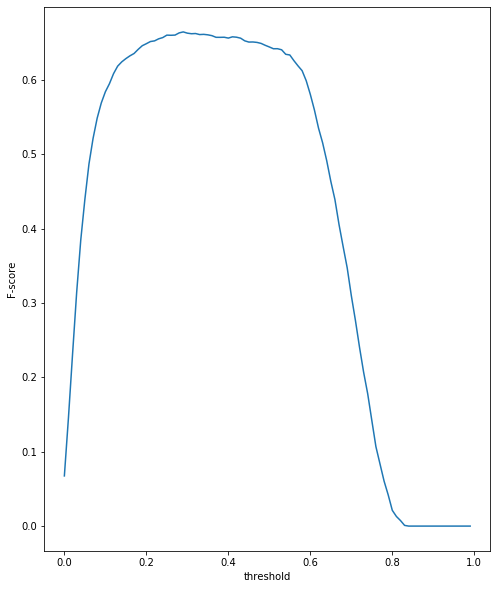

0.6648660814764799
0.87209225


In [223]:
points = []
for i in np.arange(0, 1, 0.01):
    points.append(precision_recall_fscore_support(y_train, np.greater(result, i))[2][1])

plt.plot(np.arange(0, 1, 0.01), points)
plt.ylabel('F-score')
plt.xlabel('threshold')
plt.show()
print(np.max(points))
print(np.max(result))

However, we also possess the old fetaures which have been used in the previous research. By direct usage of those we can clearly compare our performance against the performance of the previous system. Thus, we load the necessary features and scale them in order to use in the neural network.

In [225]:
x_tr = train.loc[:, 'prePause':'EminWplus1'].values
y_tr = train['boundary']

x_ts = test.loc[:, 'prePause':'EminWplus1'].values
y_ts = test['boundary']

scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)
x_ts = scaler.transform(x_ts)

We define a very simple fully connected model that will that those features in and predict the break. Once, again we use adam and binary crossentropy. For activation of the layers we use relu and after some intial test notice that overfitting is not a big problem, thus, do not include mechanisms such as the dropout or batch normalisation.

In [174]:
def FC_model():
    features_input = Input(shape=((23,)))    
    x = Dense(40, activation='relu')(features_input)    
    x = Dense(40, activation='relu')(x)    
    x = Dense(40, activation='relu')(x)    
    x = Dense(40, activation='relu')(x)    
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=features_input, outputs=x)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m, nist])
    
    return model

The training of the model is fast enough that we can do it live. We define checkpoints to save the best model and use tensorboard for data visualisation.

In [175]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_tr),
                                            np.array(y_tr).reshape(-1))
weigths = {index: value for index, value in enumerate(weights)}
model = FC_model()

name = f'BULATS-old-features-deeper-bigger-network-automatic-weights-{datetime.now().strftime("%d_%m_%Y-%H_%M_%S")}'
checkpoint = ModelCheckpoint(f'training/{name}.h5', monitor='val_f1_m', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir=f"training/tensorboard/{name}")
#             early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, min_delta=0.001)

model.fit(x_tr, y_tr, epochs=1000, batch_size=1000, callbacks=[checkpoint, tensorboard], validation_data=(x_ts, y_ts), shuffle=True, class_weight=weights)

Train on 61237 samples, validate on 6792 samples
Epoch 1/1000
61237/61237 [==============================] - 2s 30us/step - loss: 0.2323 - acc: 0.9658 - f1_m: 0.1528 - precision_m: 0.2399 - recall_m: 0.1236 - nist: 0.9800 - val_loss: 0.1261 - val_acc: 0.9678 - val_f1_m: 0.4409 - val_precision_m: 0.6859 - val_recall_m: 0.3289 - val_nist: 0.8279

Epoch 00001: val_f1_m improved from -inf to 0.44090, saving model to training/BULATS-old-features-deeper-bigger-network-automatic-weights-04_09_2019-02_32_30.h5
Epoch 2/1000
61237/61237 [==============================] - 1s 10us/step - loss: 0.1035 - acc: 0.9714 - f1_m: 0.4846 - precision_m: 0.6474 - recall_m: 0.3936 - nist: 0.8260 - val_loss: 0.1006 - val_acc: 0.9682 - val_f1_m: 0.4746 - val_precision_m: 0.6740 - val_recall_m: 0.3688 - val_nist: 0.8111

Epoch 00002: val_f1_m improved from 0.44090 to 0.47460, saving model to training/BULATS-old-features-deeper-bigger-network-automatic-weights-04_09_2019-02_32_30.h5
Epoch 3/1000
61237/61237 [====


Epoch 00042: val_f1_m did not improve from 0.70906
Epoch 43/1000
61237/61237 [==============================] - 1s 10us/step - loss: 0.0544 - acc: 0.9786 - f1_m: 0.7004 - precision_m: 0.6835 - recall_m: 0.7251 - nist: 0.6215 - val_loss: 0.0774 - val_acc: 0.9760 - val_f1_m: 0.7037 - val_precision_m: 0.6852 - val_recall_m: 0.7261 - val_nist: 0.6172

Epoch 00043: val_f1_m did not improve from 0.70906
Epoch 44/1000
61237/61237 [==============================] - 1s 10us/step - loss: 0.0543 - acc: 0.9788 - f1_m: 0.7038 - precision_m: 0.6881 - recall_m: 0.7274 - nist: 0.6120 - val_loss: 0.0787 - val_acc: 0.9750 - val_f1_m: 0.6829 - val_precision_m: 0.6754 - val_recall_m: 0.6933 - val_nist: 0.6485

Epoch 00044: val_f1_m did not improve from 0.70906
Epoch 45/1000
61237/61237 [==============================] - 1s 9us/step - loss: 0.0538 - acc: 0.9787 - f1_m: 0.6996 - precision_m: 0.6823 - recall_m: 0.7288 - nist: 0.6323 - val_loss: 0.0758 - val_acc: 0.9742 - val_f1_m: 0.6816 - val_precision_m: 

61237/61237 [==============================] - 1s 10us/step - loss: 0.0427 - acc: 0.9823 - f1_m: 0.7533 - precision_m: 0.7259 - recall_m: 0.7892 - nist: 0.5199 - val_loss: 0.0989 - val_acc: 0.9722 - val_f1_m: 0.6421 - val_precision_m: 0.6493 - val_recall_m: 0.6374 - val_nist: 0.7150

Epoch 00089: val_f1_m did not improve from 0.70906
Epoch 90/1000
61237/61237 [==============================] - 1s 10us/step - loss: 0.0426 - acc: 0.9822 - f1_m: 0.7516 - precision_m: 0.7284 - recall_m: 0.7846 - nist: 0.5209 - val_loss: 0.0992 - val_acc: 0.9716 - val_f1_m: 0.6356 - val_precision_m: 0.6393 - val_recall_m: 0.6358 - val_nist: 0.7313

Epoch 00090: val_f1_m did not improve from 0.70906
Epoch 91/1000
61237/61237 [==============================] - 1s 10us/step - loss: 0.0421 - acc: 0.9828 - f1_m: 0.7606 - precision_m: 0.7365 - recall_m: 0.7941 - nist: 0.5020 - val_loss: 0.0982 - val_acc: 0.9728 - val_f1_m: 0.6706 - val_precision_m: 0.6435 - val_recall_m: 0.7028 - val_nist: 0.6974

Epoch 00091: va

KeyboardInterrupt: 

Once trained (and tested using previously defined functions) we can evaluate which features seem to be the most important ones. For that we use Lasso method where here we evaluate the coefficients.

In [192]:
reg = LassoCV(cv=5)
reg.fit(train.loc[:, 'prePause':'EminWplus1'], train['boundary'])
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(train.loc[:, 'prePause':'EminWplus1'], train['boundary']))
coef = pd.Series(reg.coef_, index = train.loc[:, 'prePause':'EminWplus1'].columns)

Best alpha using built-in LassoCV: 0.002845
Best score using built-in LassoCV: 0.300670


The number of features rejected shows how clean the data is.

In [193]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 17 variables and eliminated the other 6 variables


To know the exact influence of all the features we plot them in a nice graph.

Text(0.5, 1.0, 'Feature importance using Lasso Model')

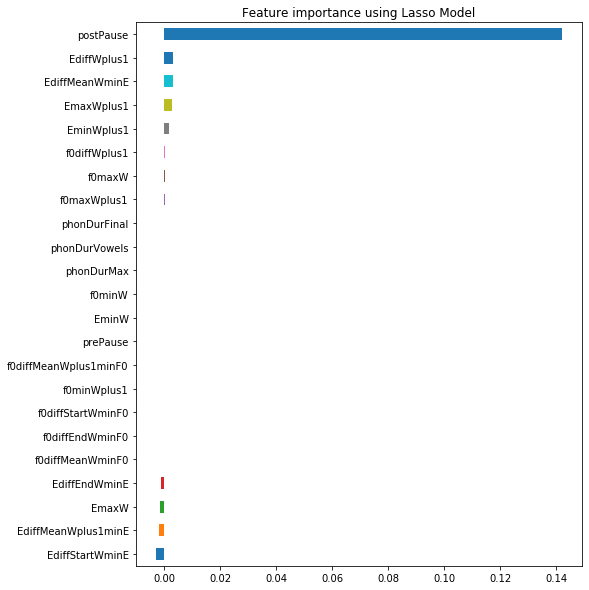

In [194]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

If we want to generate the fsts for the further processing we need to use the externally created functions in the models.py file. Those will generate the necessary fst's.

In [ ]:
from models import create_slm, create_fst_prosodic, create_fst_slm

lengths = []
current = 0
for i in train['boundary']:
    if i == 0:
        current += 1
    elif i == 1:
        lengths.append(current)
        current = 0

model = load_model("training/BULATS-old-features-bigger-network-automatic-weights-04_09_2019-02_30_55.h5", custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'nist': nist})
slm, max_seen = create_slm(lengths=lengths)
slm_non_zero, slm_zero = create_fst_slm(lengths, test['token'])
for recording in test['recording'].unique():
    x_ts = scaler.transform(test.loc[test['recording'] == recording, 'prePause':'EminWplus1'])
    prosodic_non_zero, prosodic_zero = create_fst_prosodic(model, x_ts, test.loc[test['recording'] == recording, 'token'])
    fst.compose(prosodic_zero, slm.arcsort())